In [1]:
from numpy import sin, cos
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

https://matplotlib.org/examples/animation/double_pendulum_animated.html

In [2]:
def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_)
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

In [3]:
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 0.7  # length of pendulum 2 in m
M1 = 1.5  # mass of pendulum 1 in kg
M2 = 0.75  # mass of pendulum 2 in kg

dt = 0.05
timestep = 40

[ 1.86548008  5.21400977  0.97875185  8.51761834]


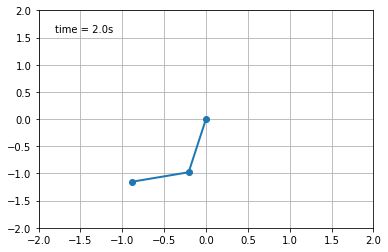

In [4]:
# create a time array from 0..100 sampled at dt second steps
t = np.arange(0.0, timestep*dt, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 100.0
w1 = 90
th2 = 0
w2 = -90

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

print(np.max(y, axis=0))

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=1000*dt, blit=True, init_func=init)

# ani.save('double_pendulum.mp4', fps=15)
HTML(ani.to_html5_video())

# Create Dataset

In [5]:
t = np.arange(0.0, timestep*dt, dt)
x = np.radians(100)

def simulate(state):
    y = integrate.odeint(derivs, state, t)
    return y

In [6]:
sample_size = 25000

X = np.zeros(shape=(sample_size, timestep, 4))
Y = np.zeros(shape=(sample_size, timestep, 4))

for i in tqdm(range(sample_size)):
    init = np.random.uniform(-x, x, 4)
    y = simulate(init)
    X[i] = np.insert(y[:-1], 0, init, axis=0)
    Y[i] = y
    
np.save("X", X)
np.save("y", Y)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [03:50<00:00, 108.37it/s]


# Create Model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model

Using TensorFlow backend.


In [29]:
X = np.load("X.npy")
Y = np.load("Y.npy")

In [43]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(timestep, 4)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(32))
model.add(Dense(4))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 40, 128)           68096     
_________________________________________________________________
lstm_27 (LSTM)               (None, 40, 128)           131584    
_________________________________________________________________
lstm_28 (LSTM)               (None, 40, 128)           131584    
_________________________________________________________________
dense_16 (Dense)             (None, 40, 32)            4128      
_________________________________________________________________
dense_17 (Dense)             (None, 40, 4)             132       
Total params: 335,524
Trainable params: 335,524
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(loss='mean_squared_error',
              optimizer='Nadam',
              metrics=["mean_squared_error", 'mean_absolute_percentage_error'])

In [45]:
model.fit(X, Y,
          epochs=20,
          batch_size=128,
          validation_split=0.2,
          verbose=2
         )

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
 - 23s - loss: 0.4546 - mean_squared_error: 0.4546 - mean_absolute_percentage_error: 132.4678 - val_loss: 0.0769 - val_mean_squared_error: 0.0769 - val_mean_absolute_percentage_error: 72.7064
Epoch 2/20
 - 20s - loss: 0.0678 - mean_squared_error: 0.0678 - mean_absolute_percentage_error: 75.6148 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_percentage_error: 52.5938
Epoch 3/20
 - 20s - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_percentage_error: 52.5516 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_percentage_error: 79.7907
Epoch 4/20
 - 20s - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_percentage_error: 42.9240 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_percentage_error: 46.6658
Epoch 5/20
 - 20s - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_percentage_error: 44.0107 - val_loss: 0.0143 - val_mean_squared_

In [50]:
model.save("model.h5")

# Generator

In [51]:
newModel = Sequential()
newModel.add(LSTM(128, stateful=True, return_sequences=True, batch_input_shape=(1, 1, 4)))
newModel.add(LSTM(128, stateful=True, return_sequences=True))
newModel.add(LSTM(128, stateful=True, return_sequences=True))
newModel.add(Dense(32))
newModel.add(Dense(4))

try:
    weight = model.get_weights()
except:
    model = load_model('model.h5')
    weight = model.get_weights()
newModel.set_weights(weight)

newModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (1, 1, 128)               68096     
_________________________________________________________________
lstm_33 (LSTM)               (1, 1, 128)               131584    
_________________________________________________________________
lstm_34 (LSTM)               (1, 1, 128)               131584    
_________________________________________________________________
dense_20 (Dense)             (1, 1, 32)                4128      
_________________________________________________________________
dense_21 (Dense)             (1, 1, 4)                 132       
Total params: 335,524
Trainable params: 335,524
Non-trainable params: 0
_________________________________________________________________


In [52]:
newModel.reset_states()

init_state = np.random.uniform(-x, x, (1, 1, 4)) 
simulation = simulate(init_state[0, 0, :])

prediction = []
state = init_state
for i in range(timestep):
    state = newModel.predict(state)
    prediction.append(state[0, 0, :])
    
prediction = np.array(prediction)

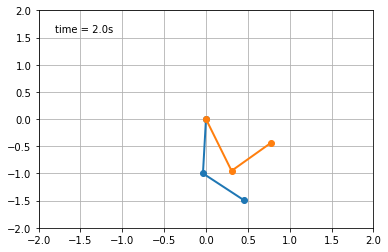

In [53]:
def init():
    line.set_data([], [])
    line2.set_data([], [])
    time_text.set_text('')
    return line, line2, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]
    
    thisx2 = [0, x3[i], x4[i]]
    thisy2 = [0, y3[i], y4[i]]

    line.set_data(thisx, thisy)
    line2.set_data(thisx2, thisy2)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

x1 = L1*sin(simulation[:, 0])
y1 = -L1*cos(simulation[:, 0])

x2 = L2*sin(simulation[:, 2]) + x1
y2 = -L2*cos(simulation[:, 2]) + y1

x3 = L1*sin(prediction[:, 0])
y3 = -L1*cos(prediction[:, 0])

x4 = L2*sin(prediction[:, 2]) + x3
y4 = -L2*cos(prediction[:, 2]) + y3

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=1000*dt, blit=True, init_func=init)

# ani.save('double_pendulum.mp4', fps=15)
HTML(ani.to_html5_video())